<a href="https://colab.research.google.com/github/sanjeevrs2000/CS6910-Assignment/blob/main/Assignment_1_deep_learning_v2_wandb_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deep Learning Assignment 1 - Fashion MNIST dataset**

#**Libraries**

In [1]:
!pip install wandb
import wandb
#wandb.login()


     |████████████████████████████████| 2.0MB 8.8MB/s 
     |████████████████████████████████| 102kB 9.0MB/s 
     |████████████████████████████████| 163kB 39.4MB/s 
     |████████████████████████████████| 133kB 32.6MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=aca707dc77d915baaa8dbc5fdae4c6d581253f7b3bdb0aad9de513aabb31bf1b
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=4c4e8238f1031ec51de0c78593b94920c31dcf65a537a83c63daa7ebf6d1d6bf
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [2]:
import numpy as np
import pandas as pd
import keras
import math
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
#import tensorflow as tf
#import tensorflow_datasets as tdfs
from sklearn.metrics import accuracy_score

**Load Dataset**

In [3]:
(trainx, trainy), (testx, testy)= fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


**Visualizing Dataset**

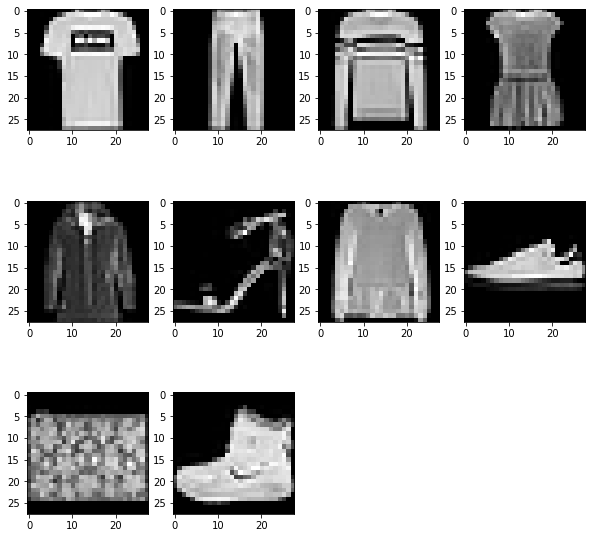

In [4]:
classes = np.unique(trainy)
index_mat = [0]*10
for i in classes:
  index_mat[i] = trainy.tolist().index(i)

plt.figure(figsize=(10,10))

for j, i in enumerate(index_mat):
  plt.subplot(3,4,j+1)
  plt.imshow(trainx[i], cmap=plt.get_cmap('gray'))
  
plt.show()

In [5]:
x_train = trainx.reshape(60000,784)/255.0
#one hot encoding y 
temp = np.zeros((60000,10))
temp[np.arange(60000),trainy] = 1
y_train=temp

#**TRAIN FUNCTION**

In [6]:
sweep_config = {
  'name': 'sweep7_v2',  
  'method': 'grid',
  'parameters': {
        'epochs': {
            'values': [10]
        },
        'batch_size':{
            'values':[32]
        },
        'hidden_layers':{
            'values':[3]
        },
        'eta': {
            'values': [0.005,1e-3]
        },
        'size1':{
            'values':[128,64]
        },
        'size2':{
            'values':[16,32]
        },
        'size3':{
            'values':[16,32]
        },
        'optimizer': {
            'values': ['adam','rmsprop']
        },
        'activation': {
            'values': ['sigmoid']
        },
        'wt_decay': {
            'values': [0.05]
        },
        'initialization' : {
            'values' : ['xavier','random']
        }
    }
}

In [7]:
def Train():            #define inputs
  
  X = x_train[:50000]
  Y = y_train[:50000]

  x_val = x_train[50000:]
  y_val = y_train[50000:]
  
  config_defaults = {
        'epochs': 10,
        'batch_size':32,
        'hidden_layers':3,
        'eta': 0.001,
        'size1':64,
        'size2':16,
        'size3':16,
        'activation': 'sigmoid',
        'optimizer': 'rmsprop',
        'wt_decay':0.05,
        'initialization':'xavier'
        }
  #config=config_defaults  #for testing

  wandb.init(config=config_defaults)

  config = wandb.config

  eta = config['eta']
  epochs = config['epochs']
  batch_size=config['batch_size']
  activation=config['activation']
  optimization=config['optimizer']
  num_hidden_layers = config['hidden_layers'] 
  size1=config['size1'] 
  size2=config['size2']  
  size3=config['size3']         
  wt_decay=config['wt_decay']
  initialization=config['initialization']   

  wandb.run.name =config['optimizer']+'eta'+str(config['eta'])+'hl'+str(config['hidden_layers'])+'hl_size1_'+str(config['size1'])+'hl_size2_'+str(config['size2'])+'hl_size3_'+str(config['size3'])+config['initialization']

  input_layer_size = 784  #input number of inputs here

  output_layer_size = 10  #input number of output nodes here

  num_nodes = [input_layer_size]

  num_nodes.append(size1)
  num_nodes.append(size2)
  num_nodes.append(size3)
  num_nodes.append(output_layer_size)

  num_weight_mat = num_hidden_layers+1


  def init_random():
    weights={}
    bias = {}
    for i in  range(1,num_weight_mat+1):
      weights['W%s'% i] = np.random.randn(int(num_nodes[i]),int(num_nodes[i-1]))
      bias['b%s'% i] = np.random.randn(int(num_nodes[i]))
    
    return weights, bias

  def init_xavier():
    weights={}
    bias = {}
    for i in  range(1,num_weight_mat+1):
      weights['W%s'%i] = np.random.normal(0, math.sqrt(1/num_nodes[i-1]) ,size=([int(num_nodes[i]),int(num_nodes[i-1])]))
      bias['b%s'%i] = np.zeros(int(num_nodes[i]))
    
    return weights, bias

  def init_zeros():
    weights={}
    bias = {}
    for i in  range(1,num_weight_mat+1):
      weights['W%s'% i] = np.zeros([int(num_nodes[i]),int(num_nodes[i-1])])
      bias['b%s'% i] = np.zeros(int(num_nodes[i]))

    return weights,bias
  
  
  #Setting weight initialization function
  
  if initialization == 'random':
    wt_init=init_random()
  elif initialization == 'xavier':
    wt_init = init_xavier()
  else:
    print('weight initialization given is not available')

  #Setting weights
  weights = {}
  bias = {}
  weights, bias = wt_init


  #Defining activation functions and their derivatives

  def sigmoid(x):
    return 1/(1+np.exp(-x))

  def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

  def relu(x):
    if x<0:
      return 0
    else:
      return x

  def grad_tanh(x):
    return 1-(tanh(x))**2

  def grad_relu(x):
    if x<0:
      return 0
    else:
      return 1

  def grad_sigmoid(x):
    return (sigmoid(x)*(1-sigmoid(x)))

  def softmax(x):
    # Numerically stable with large exponentials
    exps = np.exp(x )
    return exps / np.sum(exps)
  

  #Setting activation function and its derivative
  if activation == 'sigmoid':
    activ = sigmoid
    der_activ = grad_sigmoid
  elif activation == 'tanh':
    activ = tanh
    der_activ = grad_tanh
  elif activation == 'relu':
    activ = relu
    der_activ = grad_relu

  #Setting output function
  output = softmax 
  
  activation = activ
  der_activ = der_activ

  #Forward prop
  def forward_prop(weights, bias, x):
    Acti = {}
    H = {}
    
    H['H0'] = x
    
    for i in range(1,num_hidden_layers+1):
      Acti[('A%s'% i)] = np.matmul(weights['W%s'% i],H[('H%s'% (i-1))])+bias['b%s'% i]
      H['H%s'% i] = activation(Acti['A%s'% i])
    
    Acti['A%s'%(num_hidden_layers+1)]= np.matmul(weights['W%s'% (num_hidden_layers+1)],H['H%s'% (num_hidden_layers)])+bias['b%s'% (num_hidden_layers+1)]
    y_hat = output(Acti['A%s'% (num_hidden_layers+1)])  
    
    return y_hat, Acti, H


  #Backward prop
  def back_prop(w, b, x, y):
    grad_A = {}
    grad_W = {}
    grad_b = {}
    grad_H = {}  

    y_hat, A, H = forward_prop(w, b, x)

    grad_A['A%s'% (num_hidden_layers+1)] = -(y-y_hat)

    for i in range(num_hidden_layers+1, 1, -1):
      
      grad_W['W%s'%i] = np.matmul(grad_A['A%s'%i].reshape(-1,1), H['H%s'%(i-1)].reshape(1,-1))

      grad_b['b%s'%i] = grad_A['A%s'%i]

      grad_H['H%s'%(i-1)] = np.dot(np.transpose(w['W%s'%i]), grad_A['A%s'%i]) #check once if this is logically correct (Looks good)

      grad_A['A%s'%(i-1)] = np.multiply(grad_H['H%s'%(i-1)], der_activ(A['A%s'%(i-1)]))

    grad_W['W1'] = np.multiply(grad_A['A1'].reshape(-1,1), H['H0'].reshape(1,-1))

    grad_b['b1'] = grad_A['A1']

    return grad_W, grad_b
    

   #defining sgd
  def sgd():

    for k in range(epochs):
      for x,y in zip(X,Y):
        grad_w,grad_b=back_prop(weights, bias, x,y)
        for j in range(1,num_hidden_layers+2):
          
          weights['W%s'%j]-=(grad_w['W%s'%j])*eta
          bias['b%s'%j]-=(grad_b['b%s'%j])*eta

   #defining momentum
  def momentum_gd():

    gamma=0.9
    prev_dw,prev_db=init_zeros()

    for k in range(epochs):
      count=0   
    
      dw,db=init_zeros()
      
      for x,y in zip(X,Y):
        
        if count==0:
          dw,db=init_zeros()
        
        grad_w,grad_b=back_prop(weights, bias, x, y)

        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])



        count+=1

        if count%batch_size==0:
          
          weights['W%s'%j]-=((prev_dw['W%s'%j])*gamma+(dw['W%s'%j])*eta+(weights['W%s'%j])*wt_decay*eta)
          bias['b%s'%j]-=((prev_db['b%s'%j])*gamma+(db['b%s'%j])*eta+(bias['b%s'%j])*wt_decay*eta)

          prev_dw['W%s'%j]=(prev_dw['W%s'%j])*gamma+(dw['W%s'%j])*eta
          prev_db['b%s'%j]=(prev_db['b%s'%j])*gamma+(db['b%s'%j])*eta

          count=0

   #defining nesterov
  def nesterov():

    gamma=0.9
    prev_vw,prev_vb=init_zeros()
    temp_w,temp_b=init_zeros()
    dw,db=init_zeros()
    v_w,v_b=init_zeros()

    for k in range(epochs):
      count=0

      if count==0:
        for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j]=prev_vw['W%s'%j]*gamma 
            v_b['b%s'%j]=prev_vb['b%s'%j]*gamma 


      for x,y in zip(X,Y):
        if count==0:
          dw,db=init_zeros()

        for j in range(1,num_hidden_layers+2):
          temp_w['W%s'%j]=weights['W%s'%j]-v_w['W%s'%j]
          temp_b['b%s'%j]=bias['b%s'%j]-v_b['b%s'%j]
        
        grad_w,grad_b=back_prop(temp_w,temp_b,x,y)      
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:
          
          for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j]=(prev_vw['W%s'%j])*gamma + (dw['W%s'%j])*eta
            v_b['b%s'%j]=(prev_vb['b%s'%j])*gamma + (db['b%s'%j])*eta
            weights['W%s'%j]-=(v_w['W%s'%j]+(weights['W%s'%j])*wt_decay*eta)
            bias['b%s'%j]-=(v_b['b%s'%j]+(bias['b%s'%j])*wt_decay*eta)
            prev_vw['W%s'%j]=v_w['W%s'%j]
            prev_vb['b%s'%j]=v_b['b%s'%j]

          count=0

   #defining adagrad
  def adagrad():
  
    eps = 1e-8

    v_w,v_b=init_zeros()

    for k in range(epochs):
      count=0
      dw,db=init_zeros()
      
      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros()
        
        grad_w,grad_b=back_prop( weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:

          for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j] += np.square(dw['W%s'%j])
            v_b['b%s'%j] += np.square(db['b%s'%j]) 
            weights['W%s'%j] -= ((dw['W%s'%j])*(eta/np.sqrt(v_w['W%s'%j] + eps))+(weights['W%s'%j])*wt_decay*eta)
            bias['b%s'%j] -= ((db['b%s'%j])*(eta/np.sqrt(v_b['b%s'%j] + eps))+(bias['b%s'%j])*wt_decay*eta)

            count=0

   #defining rmsprop
  def rmsprop():
  
    eps = 1e-8
    beta1 = 0.9

    v_w,v_b=init_zeros()

    for k in range(epochs):
      count=0
      dw,db=init_zeros()
      
      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros()
        
        grad_w,grad_b=back_prop( weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:

          for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j] = beta1*v_w['W%s'%j] + (1-beta1)*np.square(dw['W%s'%j])
            v_b['b%s'%j] = beta1*v_b['b%s'%j] + (1-beta1)*np.square(db['b%s'%j]) 
            weights['W%s'%j] -= ((dw['W%s'%j])*(eta/np.sqrt(v_w['W%s'%j] + eps))+(weights['W%s'%j])*wt_decay*eta)
            bias['b%s'%j] -= ((db['b%s'%j])*(eta/np.sqrt(v_b['b%s'%j] + eps))+(bias['b%s'%j])*wt_decay*eta)

            count=0

   #defining adam 
  def adam():
  
    eps = 1e-8
    beta1 = 0.9
    beta2 = 0.999

    v_w,v_b=init_zeros()
    v_w_hat,v_b_hat=init_zeros()

    m_w,m_b=init_zeros()
    m_w_hat,m_b_hat=init_zeros()

    for k in range(epochs):
      
      count=0
      dw,db=init_zeros()
      
      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros()
        
        grad_w,grad_b=back_prop( weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:

          for j in range(1,num_hidden_layers+2):
            
            v_w['W%s'%j] = beta2*v_w['W%s'%j] + (1-beta2)*np.square(dw['W%s'%j])
            v_b['b%s'%j] = beta2*v_b['b%s'%j] + (1-beta2)*np.square(db['b%s'%j]) 

            v_w_hat['W%s'%j] = v_w['W%s'%j]*1/(1-math.pow(beta2,k+1))
            v_b_hat['b%s'%j] = v_b['b%s'%j]*1/(1-math.pow(beta2,k+1))

            m_w['W%s'%j] = beta1*m_w['W%s'%j] + (1-beta1)*(dw['W%s'%j])
            m_b['b%s'%j] = beta1*m_b['b%s'%j] + (1-beta1)*(db['b%s'%j]) 

            m_w_hat['W%s'%j] = m_w['W%s'%j]*1/(1-math.pow(beta1,k+1))
            m_b_hat['b%s'%j] = m_b['b%s'%j]*1/(1-math.pow(beta1,k+1))
            
            weights['W%s'%j] -= ((m_w_hat['W%s'%j])*(eta/np.sqrt(v_w_hat['W%s'%j] + eps))+(weights['W%s'%j])*wt_decay*eta) 
            bias['b%s'%j] -= ((m_b_hat['b%s'%j])*(eta/np.sqrt(v_b_hat['b%s'%j] + eps))+(bias['b%s'%j])*wt_decay*eta)

            count=0
  
  #Error and validation functions

  def error(y, y_hat):
    return -np.log(np.dot(y, y_hat))

  def val_accuracy():
    y_pred=np.zeros(10000)
    fx=np.zeros([10000,10])
    val_loss=0
    for i in range(10000):
      fx[i]=forward_prop(weights,bias,x_val[i])[0]
      val_loss+=error(y_val[i],fx[i])
    y_pred=np.argmax(fx,axis=1)   
    y_val_=np.argmax(y_val,axis=1)

    val_accuracy=accuracy_score(y_pred,y_val_)
    return val_loss,val_accuracy


  #Setting optimization function
  if optimization == 'sgd':
    sgd()
  elif optimization == 'momentum':
    momentum_gd()
  elif optimization == 'nesterov':
    nesterov()
  elif optimization == 'rmsprop':
    rmsprop()
  elif optimization =='adam':
    adam()
  elif optimization =='adagrad':
    adagrad()  
  else:
    print('Optimization algo given is not available')

  val_loss,val_acc = val_accuracy()
  print(val_loss)

  params={'epochs':epochs,'learning rate':eta,'no of hidden layers':num_hidden_layers,'batch size':batch_size,'optimizer':optimization,'validation accuracy':val_acc}
  wandb.log(params)

#**Check**

In [8]:
#Train()

In [9]:
sweep_id = wandb.sweep(sweep_config,entity='nimeesh',project='assignment1')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 0u4987pw
Sweep URL: https://wandb.ai/nimeesh/assignment1/sweeps/0u4987pw


In [ ]:
wandb.agent(sweep_id, Train)

wandb: Agent Starting Run: gqfysjju with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: adam
wandb: 	size1: 128
wandb: 	size2: 16
wandb: 	size3: 16
wandb: 	wt_decay: 0.05
wandb: Currently logged in as: nimeesh (use `wandb login --relogin` to force relogin)


5090.5128234817075


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,adam
validation accuracy,0.8463
_runtime,512
_timestamp,1615611510
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6rr8yom4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: adam
wandb: 	size1: 128
wandb: 	size2: 16
wandb: 	size3: 32
wandb: 	wt_decay: 0.05


4818.73617935251


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,adam
validation accuracy,0.8435
_runtime,518
_timestamp,1615612036
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: l157639x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: adam
wandb: 	size1: 128
wandb: 	size2: 32
wandb: 	size3: 16
wandb: 	wt_decay: 0.05


4765.173040928283


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,adam
validation accuracy,0.8515
_runtime,519
_timestamp,1615612561
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: gsqseme3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: adam
wandb: 	size1: 128
wandb: 	size2: 32
wandb: 	size3: 32
wandb: 	wt_decay: 0.05


4350.436949571502


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,adam
validation accuracy,0.8589
_runtime,521
_timestamp,1615613087
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: d1lxlwl1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: adam
wandb: 	size1: 64
wandb: 	size2: 16
wandb: 	size3: 16
wandb: 	wt_decay: 0.05


5201.645054653245


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,adam
validation accuracy,0.8441
_runtime,344
_timestamp,1615613436
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 0kf1w2h8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: adam
wandb: 	size1: 64
wandb: 	size2: 16
wandb: 	size3: 32
wandb: 	wt_decay: 0.05


4814.76260222635


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,adam
validation accuracy,0.8469
_runtime,347
_timestamp,1615613788
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 13vw3xnd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: adam
wandb: 	size1: 64
wandb: 	size2: 32
wandb: 	size3: 16
wandb: 	wt_decay: 0.05


4863.8281047283845


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,adam
validation accuracy,0.8496
_runtime,353
_timestamp,1615614147
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: yuzztk2i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: adam
wandb: 	size1: 64
wandb: 	size2: 32
wandb: 	size3: 32
wandb: 	wt_decay: 0.05


4593.257227362315


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,adam
validation accuracy,0.8488
_runtime,356
_timestamp,1615614508
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1m2fa629 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: rmsprop
wandb: 	size1: 128
wandb: 	size2: 16
wandb: 	size3: 16
wandb: 	wt_decay: 0.05


4226.484319808719


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,rmsprop
validation accuracy,0.8516
_runtime,480
_timestamp,1615614995
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: eljkfhqy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: rmsprop
wandb: 	size1: 128
wandb: 	size2: 16
wandb: 	size3: 32
wandb: 	wt_decay: 0.05


4211.016550598374


epochs,10
learning rate,0.005
no of hidden layers,3
batch size,32
optimizer,rmsprop
validation accuracy,0.8513
_runtime,484
_timestamp,1615615485
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
batch size,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p8yep076 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	initialization: xavier
wandb: 	optimizer: rmsprop
wandb: 	size1: 128
wandb: 	size2: 32
wandb: 	size3: 16
wandb: 	wt_decay: 0.05
